In [1]:
import os
import numpy as np
import cv2

import warnings
warnings.catch_warnings 

warnings.catch_warnings

In [2]:
class IDL:
    """Given a directory for images and a directory for masks, it stores the path names,
    And returns information about the image, along with the image itself, when iterated through.
    
    :param img_directory: The file path to the folder containing the images
    :param mask_directory: The file path to the folder containing the images
    
    :yield:s img_rgb, img_gray, mask, name when iterated through.
    
    """
    def __init__(self, img_directory, mask_directory, transform=None):

        # set up the lists to store image and mask file names
        self.transform = transform
        self.img_list = []
        self.mask_list = []

        # set up counter to keep track of the amount of name inconsistencies
        self.lost = 0
        
        # iterate through the masks folder to save the individual file paths
        for f in os.listdir(mask_directory):

            # if the file is in a valid format
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                
                # different directories or mask file
                if mask_directory != img_directory or '_mask' in f:

                    # get the full path of the mask
                    mask_path = os.path.join(mask_directory, f)

                    # get the name of the corresponding image
                    img_name = f.replace('_mask', '')

                    # get the full path of the image
                    img_path = os.path.join(img_directory, img_name)
                
                # same directories and image file
                else:

                    # get the full path of the image
                    img_path = os.path.join(img_directory, f)

                    # get the name of the corresponding mask
                    name, ext = os.path.splitext(f)
                    mask_name = f"{name}_mask{ext}"

                    # get the full path of the mask
                    mask_path = os.path.join(mask_directory, mask_name)

                # append mask and image to the relative lists
                self.img_list.append(img_path)
                self.mask_list.append(mask_path) 

        if not self.img_list:
            raise ValueError("No image files found in the directory.")

        # get the total number of files
        self.num_sample = len(self.img_list)
        
    def __len__(self):
        return self.num_sample

    def __iter__(self):
        for i in range(self.num_sample):
            
            # try to load the image and mask, if one of the two leads to no such file, update loss counter
            try:
                img_rgb, img_gray = readImageFile(self.img_list[i])
                mask_og = readImageFile(self.mask_list[i], is_mask= True)
                mask = (mask_og > 127).astype(np.uint8) # mask as binary
                # if the mask only contains 0s, update counter and skip
                unique_vals = np.unique(mask)
                if len(unique_vals) == 1 and int(unique_vals[0]) == 0:
                    print(f"{self.img_list[i]}: black mask")
                    self.lost += 1
                    continue

                if self.transform:
                    img_rgb = self.transform(img_rgb)
                    img_gray = self.transform(img_gray)
            
                #obtain file name
                name = self.img_list[i].split("/")[-1]

                # yield necessary informations
                yield img_rgb, img_gray, mask, mask_og, name
            
            except Exception:
                print(f"{self.img_list[i]}: inconsistent naming")
                self.lost += 1
                continue

def readImageFile(file_path, is_mask = False): # added is_mask parameter
    """Given a path, the corresponding image will be loaded in both rgb and grayscale color format.
    If the given image is indicated to be a mask, it will only be loaded in grayscale
    
    :param file_path: The image path
    :param is_mask: Defaulted to False, if set to True it only loads the mask image in grayscale
    
    :return: RGB and Grayscale image, or Grayscale mask.
    
    """
    # if we want to load a binary mask, we read the file in grayscale format
    if is_mask:
        
        mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        
        return mask
    
    # else we proceed normally

    # read image as an 8-bit array
    img_bgr = cv2.imread(file_path)

    # convert to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # convert the original image to grayscale
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    return img_rgb, img_gray

In [10]:
# set up relevant directories
img_dir = str("../data/lesion_imgs/")
mask_dir = str("../data/lesion_masks/")

data_loader = IDL(img_dir, mask_dir)

# iterate through the pairs
for img_rgb, _, mask, mask_gs, name in data_loader:
    continue

print(data_loader.lost)

../data/lesion_imgs/PAT_104_1755_320.png: black mask
../data/lesion_imgs/PAT_117_2_983.png: inconsistent naming
../data/lesion_imgs/PAT_177_11_786.png: inconsistent naming
../data/lesion_imgs/PAT_180_10_831.png: inconsistent naming
../data/lesion_imgs/PAT_181_12_158.png: inconsistent naming
../data/lesion_imgs/PAT_181_13_109.png: inconsistent naming
../data/lesion_imgs/PAT_1893_3761_666.png: black mask
../data/lesion_imgs/PAT_202_19_612.png: inconsistent naming
../data/lesion_imgs/PAT_202_25_942.png: inconsistent naming
../data/lesion_imgs/PAT_223_33_246.png: inconsistent naming
../data/lesion_imgs/PAT_233_27_663.png: inconsistent naming
../data/lesion_imgs/PAT_236_7_180.png: inconsistent naming
../data/lesion_imgs/PAT_256_4_583.png: inconsistent naming
../data/lesion_imgs/PAT_258_8_198.png: inconsistent naming
../data/lesion_imgs/PAT_260_35_396.png: inconsistent naming
../data/lesion_imgs/PAT_265_39_303.png: inconsistent naming
../data/lesion_imgs/PAT_275_9_966.png: inconsistent namin

In [ ]:
import matplotlib.pyplot as plt

img_rgb, _ = readImageFile("../data/lesion_imgs/PAT_104_1755_320.png")
img_mask = readImageFile("../data/lesion_masks/PAT_104_1755_320_mask.png", is_mask= True)

fig = plt.figure(figsize= (12, 5))
fig1 = fig.add_subplot(1, 2, 1)
fig1.set_axis_off()
fig1.set_title("PAT_104_1755_320.png")
fig1.imshow(img_rgb)

fig2 = fig.add_subplot(1, 2, 2)
fig2.set_axis_off()
fig2.set_title("PAT_104_1755_320_mask.png")
fig2.imshow(img_mask, cmap= 'gray')

fig.savefig("../data/black_mask_example.pdf", dpi=300)
plt.close()
print("Plot saved as [black_mask_example.pdf] in the /data directory.")


<class 'numpy.ndarray'>
uint8
(1001, 1001)
Plot saved as [black_mask_example.pdf] in the /data directory.


In [ ]:
import numpy as np
from skimage.measure import label
from scipy.ndimage import binary_dilation, generate_binary_structure

def fCHEESE_extractor(mask) -> int:
    """Counts the number of connected components in the given binary mask.
    
    :param mask: The binary mask to be analyzed
    :return: The number of connected components in the mask
    
    """

    # create cross-shaped structure to dilate
    structure = generate_binary_structure(mask.ndim, 1)

    # dilate mask to close small gaps
    cc_list = []

    # dilate an increasing amount of times, save n. of cc for each iteration.
    # necessary since some masks do not behave as expected (potentially invisible
    # gaps make the number of cc skyroket, this prevents that, or at least provides
    # a more accurate estimate)
    for i in range(5, 26, 5):
        dilated_mask = binary_dilation(mask, structure= structure, iterations= i)

        # label mask
        labeled_mask = label(dilated_mask, connectivity= 2)

        # find number of cc: label() assigns an integer to
        # each cc, so the max value will be the total n of ccs.
        cc = labeled_mask.max()
        
        # append result
        cc_list.append(cc)
    
    # also normal labelling to plot
    raw_cc = label(mask, connectivity= 2).max()
    
    # return mean cc number
    return sum(cc_list) // len(cc_list), raw_cc


In [31]:
# set up relevant directories
img_dir = str("../data/lesion_imgs/")
mask_dir = str("../data/lesion_masks/")

data_loader = IDL(img_dir, mask_dir)

# iterate through the pairs
for img_rgb, _, mask, mask_gs, name in data_loader:
    mean_cc, raw_cc = fCHEESE_extractor(mask)
    print(f"{name}: mean cc = {mean_cc}, raw cc = {raw_cc}")

    

PAT_1000_31_620.png: mean cc = 1, raw cc = 1
PAT_1006_53_385.png: mean cc = 2, raw cc = 2
PAT_1006_53_716.png: mean cc = 1, raw cc = 3
PAT_1008_59_297.png: mean cc = 1, raw cc = 1
PAT_100_393_898.png: mean cc = 1, raw cc = 1
PAT_1013_82_876.png: mean cc = 1, raw cc = 1
PAT_1014_86_861.png: mean cc = 1, raw cc = 1
PAT_1017_97_577.png: mean cc = 1, raw cc = 1
PAT_1018_107_68.png: mean cc = 1, raw cc = 1
PAT_101_1041_651.png: mean cc = 1, raw cc = 1
PAT_101_1041_658.png: mean cc = 1, raw cc = 1
PAT_101_1041_898.png: mean cc = 1, raw cc = 1
PAT_1020_111_593.png: mean cc = 1, raw cc = 1
PAT_1021_112_40.png: mean cc = 1, raw cc = 1
PAT_1022_114_756.png: mean cc = 1, raw cc = 1
PAT_1022_115_132.png: mean cc = 2, raw cc = 4
PAT_1026_124_346.png: mean cc = 1, raw cc = 1
PAT_1027_128_854.png: mean cc = 2, raw cc = 2
PAT_1029_135_239.png: mean cc = 1, raw cc = 1
PAT_1029_135_983.png: mean cc = 2, raw cc = 2
PAT_1031_148_66.png: mean cc = 1, raw cc = 2
PAT_1033_153_301.png: mean cc = 1, raw cc = 1

KeyboardInterrupt: 

C:\Users\piras\AppData\Local\Temp\ipykernel_11792\891648039.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


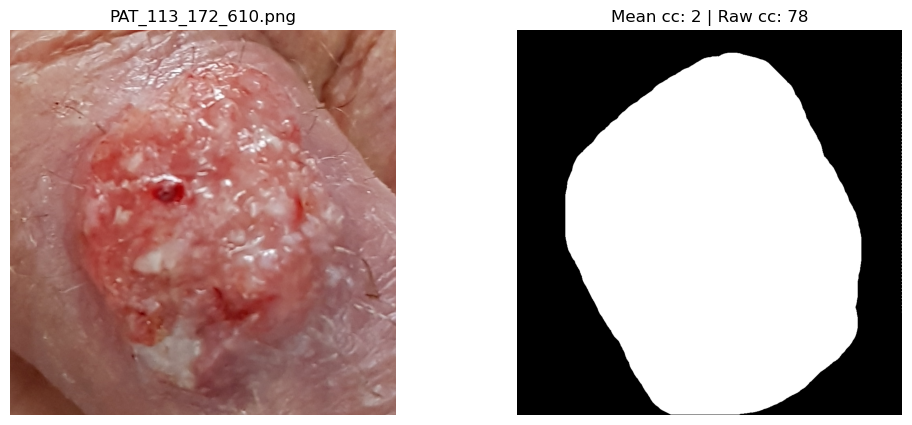

In [ ]:
img_rgb, _ = readImageFile("../data/lesion_imgs/PAT_113_172_610.png")
img_mask = readImageFile("../data/lesion_masks/PAT_113_172_610_mask.png", is_mask= True)
img_mask = (img_mask > 127).astype(np.uint8)

mean_cc, raw_cc = fCHEESE_extractor(img_mask)

fig = plt.figure(figsize= (12, 5))
fig1 = fig.add_subplot(1, 2, 1)
fig1.set_axis_off()
fig1.set_title(f"PAT_113_172_610.png")
fig1.imshow(img_rgb)

fig2 = fig.add_subplot(1, 2, 2)
fig2.set_axis_off()
fig2.set_title(f"Mean cc: {mean_cc} | Raw cc: {raw_cc}")
fig2.imshow(img_mask, cmap= 'gray')

fig.savefig("../data/cc_comparison.pdf", dpi=300)
plt.close()
print("Plot saved as [cc_comparison.pdf] in the /data directory.")

In [ ]:
img_rgb, _ = readImageFile("../data/lesion_imgs/PAT_1216_759_542.png")
img_mask = readImageFile("../data/lesion_masks/PAT_1216_759_542_mask.png", is_mask= True)
img_mask = (img_mask > 127).astype(np.uint8)
img_lesion = img_rgb.copy()
img_lesion[img_mask == 0] = [0, 0, 0]

fig = plt.figure(figsize= (12, 5))
fig1 = fig.add_subplot(1, 3, 1)
fig1.set_axis_off()
fig1.set_title(f"PAT_1216_759_542.png")
fig1.imshow(img_rgb)

fig2 = fig.add_subplot(1, 3, 2)
fig2.set_axis_off()
fig2.set_title(f"PAT_1216_759_542_mask.png")
fig2.imshow(img_mask, cmap= 'gray')

fig3 = fig.add_subplot(1, 3, 3)
fig3.set_axis_off()
fig3.set_title(f"PAT_1216_759_542.png - Masked")
fig3.imshow(img_lesion)

fig.savefig("../data/good_example.pdf", dpi=300)
plt.close()
print("Plot saved as [good_example.pdf] in the /data directory.")

Plot saved as [good_example.png] in the /data directory.
